## Загрузка данных

In [310]:
# Датасет был загружен на Google Drive
!unzip -qq /content/drive/MyDrive/flowers_dataset/flowers_dataset.zip -d .

In [185]:
import os

# Создание списка полных путей к изображениям и
# списка классов
images_filenames = list()
labels = list()
DATA_PATH = "/content/flowers"
for root, folders, files in os.walk(DATA_PATH):
  images_filenames += [os.path.join(root, f) for f in files]
  label = root.split("/")[-1]
  labels += [label for i in range(len(files))]


In [230]:
from sklearn.model_selection import train_test_split

# Создание тренировочного, проверочного, тестового наборов

X_train, X_test, y_train, y_test = train_test_split(
    images_filenames, labels, test_size=0.15, random_state=1, stratify=labels
)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, stratify=y_train
)

print("Количество тренировочных изображений: ", len(X_train))
print("Количество проверочных изображений: ", len(X_valid))
print("Количество тестовых изображений: ", len(X_test))

Количество тренировочных изображений:  2935
Количество проверочных изображений:  734
Количество тестовых изображений:  648


## Тренировка модели

In [231]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import albumentations as A

class FlowersDataGenerator(tf.keras.utils.Sequence):
  """
  Загрузчик данных. В каждую эпоху формирует 2n пар изображений,
  где n - общее количество изображений. Для каждого изображения
  существует m1 пар с изображением того же класса (метка равна 0), где
  m1 - количество изображений класса m1, и m1 пар с изображениями других
  классов (метка равна 1).

  Параметры:
  image_pathes - список полных путей к изображениям
  labels - список классов
  batch_size - размер пакета
  img_shape - размер изображения
  augmentation - флаг расширения выборки изображений
  shuffle - флаг перемешивания данных
  """

  def __init__(self, image_pathes, labels, batch_size=32, img_shape=(200, 200), augmentation=False, shuffle=True):
    self.image_pathes = image_pathes
    self.shuffle = shuffle
    self.split_by_classes = self.__create_split(labels)
    self.length = len(image_pathes) * 2
    self.batch_size = batch_size
    self.img_shape = img_shape
    self.indexes = self.__make_pairs()
    self.augmentation = augmentation
    self.transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(rotate_limit=(-30, 30), \
                       border_mode=cv2.BORDER_REPLICATE, p=0.5)
])

  def __len__(self):
    """Возвращает количество тренировочных пакетов"""
    if self.shuffle:
      self.indexes = self.__make_pairs()
    return self.length // self.batch_size

  def __create_split(self, y):
    """
    Создает словарь split_by_classes, где
    split_by_classes[label] содержит список индексов путей
    из списка с метками y соответствующего класса

    Параметры:
    y - список классов цветов
    """
    split_by_classes = dict()
    for label in list(set(y)):
      split_by_classes[label] = list()

    for i, label in enumerate(y):
      split_by_classes[label].append(i)

    return split_by_classes


  def __create_pos_neg(self, split, label, num_labels):
    """
    Создает массив троек вида (left_label, right_other, closeness),
    где left_label - индекс (в массиве self.image_pathes) изображения класса label,
    right_other - индекс изображения класса label (тогда closeness = 0) или
    индекс изображения класса отличного от класса label (тогда closeness = 1)

    Параметры:
    split - словарь из метода create_split
    label - класс, для которого формируется обучающая подвыборка
    num_labels - общее количество классов
    """
    # Индексы изображения конкретного класса
    label_images = split[label]
    left = label_images + label_images
    num_from_each = len(label_images) // (num_labels - 1) + (num_labels - 1)

    # "Похожие" изображения
    right_positive = split[label].copy()
    shuffle(right_positive)

    # "Непохожие" изображения
    right_negative = list()
    for k, v in split.items():
      if k == label:
        continue
      right_negative += v[:num_from_each]

    # Приведение к numpy
    right_positive = np.array(right_positive)[:, np.newaxis]
    half = right_positive.shape[0]

    left, right_negative = np.array(left)[:, np.newaxis], np.array(right_negative)[:, np.newaxis]
    right_negative = right_negative[:half, :]

    right = np.concatenate((right_positive, right_negative), axis=0)
    labels = np.repeat(np.array([0, 1]), np.array([half, half]))[:, np.newaxis]
    return np.concatenate((left, right, labels), axis=1)

  def __make_pairs(self):
    """
    Применяет метод create_pos_neg последовательно к
    каждому классу изображений и объединяет результаты
    """

    for k in self.split_by_classes.keys():
      shuffle(self.split_by_classes[k])

    indexes = list()
    num_labels = len(list(self.split_by_classes.keys()))
    for key in self.split_by_classes.keys():
      indexes.append(self.__create_pos_neg(self.split_by_classes, key, num_labels))

    indexes = np.concatenate(indexes, axis=0)
    np.random.shuffle(indexes)
    return indexes

  def on_epoch_end(self):
    """Перемешивает данные"""
    # Не работает из-за ошибки в коде keras.
    # Перемешивание перенесено в код метода __len__
    pass

  def __preprocess_input(self, img):
    """
    Предобработка изображения и применение аугментаций,
    если требуется
    """
    if self.augmentation:
      img = self.transform(image=img)['image']
    img = tf.cast(img, tf.float32)
    img = img / 255
    return img

  def __get_image(self, file_id):
    img = cv2.imread(file_id)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, self.img_shape)
    img = self.__preprocess_input(img)
    return img

  def __getitem__(self, idx):
    batch_x, batch_y = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size, :2], \
              self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size, 2]

    images_batch = list()
    for pair in batch_x:
      first, second = self.image_pathes[pair[0]], self.image_pathes[pair[1]]
      images_batch.append([self.__get_image(first), self.__get_image(second)])

    return tf.convert_to_tensor(images_batch), tf.convert_to_tensor(batch_y)

In [232]:
from keras import layers
from keras.applications import VGG16
from keras import Model

keras.utils.set_random_seed(1)

#------ Сверточная основа ------
target_shape = (200, 200, 3)
base_cnn = VGG16(weights='imagenet',
  include_top=False,
  input_shape=target_shape)

#------ Классификатор ------
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(256, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
output = layers.Dense(64)(dense1)

embedding = Model(base_cnn.input, output, name="Embedding")

# Заморозка части слоев
trainable = False
for layer in base_cnn.layers:
    if layer.name == "block5_conv1":
        trainable = True
    layer.trainable = trainable

In [233]:
from keras import ops
import keras


def euclidean_distance(vects):
    """
    Функция для рассчета евклидовой метрики
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

# Разделение изображений
inpt = layers.Input((2, *target_shape))
input_1 = layers.Lambda(lambda x: x[:, 0, :, :, :])(inpt)
input_2 = layers.Lambda(lambda x: x[:, 1, :, :, :])(inpt)

# Параллельный запуск с общими весами
head_1 = embedding(input_1)
head_2 = embedding(input_2)

# Вычисление дистанции между векторами, нахождение "схожести"
merge_layer = layers.Lambda(euclidean_distance, output_shape=(1,))(
    [head_1, head_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[inpt], outputs=output_layer)


In [234]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [235]:
from keras import optimizers

# Компиляция
margin = 1
siamese.compile(loss=loss(margin=margin), optimizer=optimizers.RMSprop(learning_rate=5e-5), metrics=["acc"])
siamese.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 2, 200,    │          0 │ -                 │
│ (InputLayer)        │ 200, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_56 (Lambda)  │ (None, 200, 200,  │          0 │ input_layer_40[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_57 (Lambda)  │ (None, 200, 200,  │          0 │ input_layer_40[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 64)        │ 19,451,008 │ lambda_56[0][0],  │
│ (Functional)        │                   │            │ lambda_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_58 (Lambda)  │ (None, 1)         │          0 │ Embedding[0][0],  │
│                     │                   │            │ Embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,451,014 (74.20 MB)

 Trainable params: 11,815,236 (45.07 MB)

 Non-trainable params: 7,635,778 (29.13 MB)

In [236]:
import random
from random import shuffle

random.seed(1)

# Создание генераторов данных
train_generator = FlowersDataGenerator(X_train, y_train, batch_size=32, augmentation=True)
valid_generator = FlowersDataGenerator(X_valid, y_valid, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [237]:
!mkdir /content/models

mkdir: cannot create directory ‘/content/models’: File exists


In [238]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/models/best_vgg.weights.h5', save_best_only=True, monitor='val_acc', mode='max',\
                           save_freq="epoch", save_weights_only=True)

# Тренировка
history = siamese.fit(
  x=train_generator,
  steps_per_epoch=len(train_generator),
  epochs=20,
  validation_data=valid_generator,
  validation_steps=len(valid_generator),
  callbacks=[earlyStopping, mcp_save])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1090']
Received: inputs=Tensor(shape=(None, 2, 200, 200, 3))
  warnings.warn(msg)


183/183 ━━━━━━━━━━━━━━━━━━━━ 124s 653ms/step - acc: 0.6140 - loss: 0.2318 - val_acc: 0.7528 - val_loss: 0.1765
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 124s 681ms/step - acc: 0.7696 - loss: 0.1723 - val_acc: 0.8111 - val_loss: 0.1531
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 143s 684ms/step - acc: 0.8328 - loss: 0.1541 - val_acc: 0.8368 - val_loss: 0.1478
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 159s 778ms/step - acc: 0.8468 - loss: 0.1462 - val_acc: 0.8160 - val_loss: 0.1521
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 201s 775ms/step - acc: 0.8888 - loss: 0.1329 - val_acc: 0.8486 - val_loss: 0.1439
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 146s 796ms/step - acc: 0.8978 - loss: 0.1278 - val_acc: 0.8521 - val_loss: 0.1409
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 172s 630ms/step - acc: 0.9341 - loss: 0.1171 - val_acc: 0.8660 - val_loss: 0.1345
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 119s 650ms/step - acc: 0.9367 - loss: 0.1132 - val_acc: 0.8646 - val_loss: 0.1349
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## Тестирование и нахождение ближайшего вектора

In [239]:
siamese.load_weights("/content/models/best_vgg.weights.h5")

In [240]:
test_generator = FlowersDataGenerator(X_test, y_test, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [241]:
siamese.evaluate(test_generator, batch_size=32, steps=len(test_generator), shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - acc: 0.8736 - loss: 0.1275


[0.12665334343910217, 0.8773437738418579]

In [244]:
siamese.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 2, 200,    │          0 │ -                 │
│ (InputLayer)        │ 200, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_56 (Lambda)  │ (None, 200, 200,  │          0 │ input_layer_40[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_57 (Lambda)  │ (None, 200, 200,  │          0 │ input_layer_40[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 64)        │ 19,451,008 │ lambda_56[0][0],  │
│ (Functional)        │                   │            │ lambda_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_58 (Lambda)  │ (None, 1)         │          0 │ Embedding[0][0],  │
│                     │                   │            │ Embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,266,252 (119.27 MB)

 Trainable params: 11,815,236 (45.07 MB)

 Non-trainable params: 7,635,778 (29.13 MB)

 Optimizer params: 11,815,238 (45.07 MB)

In [253]:
# Формирование кодировщика
encoder_output = siamese.get_layer("Embedding").output
encoder_input = siamese.get_layer("Embedding").input
encoder = Model(inputs=encoder_input, outputs=encoder_output)

In [254]:
from keras.preprocessing import image
from tqdm import tqdm

# Набор векторов
vectors = list()
for img in tqdm(X_test):
  img = image.load_img(img, target_size=target_shape[:-1])
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  processed_image = np.array(img, dtype="float") / 255.0
  output = encoder(processed_image)
  vectors.append(output)

100%|██████████| 648/648 [00:20<00:00, 31.68it/s]


In [260]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Сохранение в виде дерева
X = np.array(vectors)
X = np.reshape(X, (-1, 64))

knn = NearestNeighbors(n_neighbors=6)
knn.fit(X)



NearestNeighbors(n_neighbors=6)

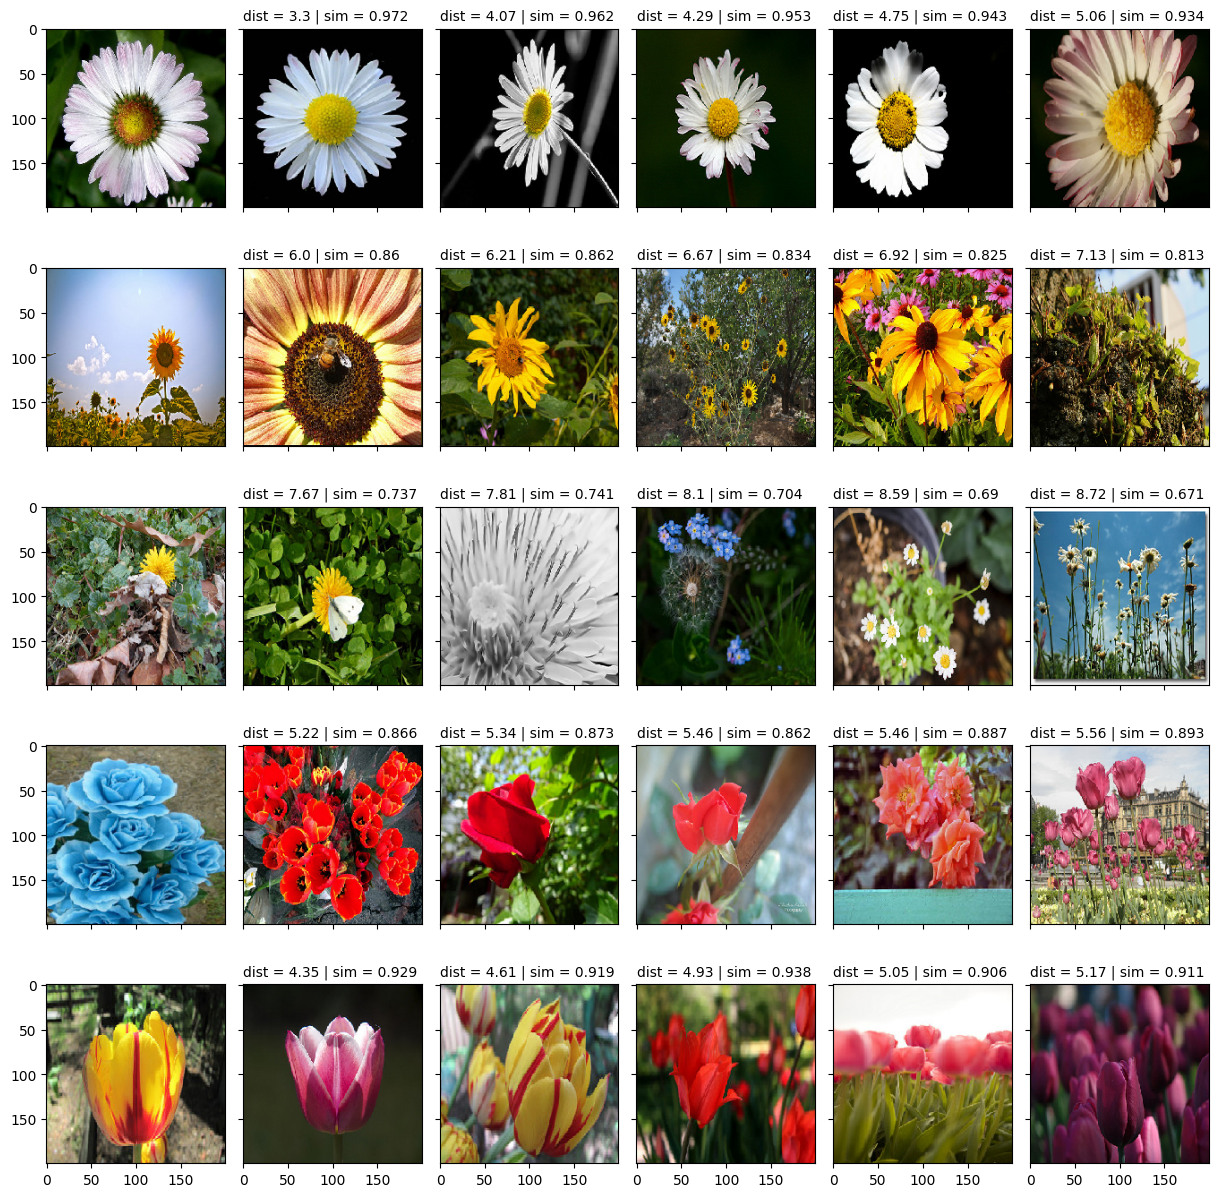

In [307]:
# Рисование наиболее похожих изображений
# для пяти случайных тестовых примеров

from numpy import dot
from numpy.linalg import norm


def cosine_similarity(a, b):
  return round(dot(a, b)/(norm(a)*norm(b)), 3)

def load_img(path):
  img = image.load_img(img, target_size=target_shape[:-1])
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  processed_image = np.array(img, dtype="float") / 255.0

n = 5
random_images_indexes = random.sample(range(0, len(X_test)), 5)

fig, axes = plt.subplots(nrows=n, ncols=n+1, sharex=True, sharey=True, figsize=(15, 15))
fig.subplots_adjust(wspace=0.1)
for i, image_index in enumerate(random_images_indexes):
  dists, neighbors = knn.kneighbors(X[image_index].reshape(1, -1), return_distance=True)
  baseline_image = image.load_img(X_test[image_index], target_size=target_shape[:-1])

  for j, neighbor in enumerate(neighbors[0]):
    cur = image.load_img(X_test[neighbor], target_size=target_shape[:-1])
    axes[i, j].imshow(cur)
    if j:
      axes[i, j].text(0, -10, s="dist = " + str(round(dists[0][j], 2)) + \
                      " | sim = " + str(cosine_similarity(X[image_index], X[neighbor])))